In [1]:
import autoreload
%reload_ext autoreload
%autoreload 2

In [2]:
import os

import time
import progressbar
import warnings
import copy
import pandas as pd
import numpy as np
from io import BytesIO
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image

import torch
import torch.utils.data as utils
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch.nn import ReLU

from multiprocessing import cpu_count
from torch.multiprocessing import Pool

%matplotlib inline
plt.style.use('seaborn')

warnings.filterwarnings("ignore")
torch.set_num_threads(1)

In [3]:
# config
BATCH_SIZE = 32
EPOCH = 25
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
def read_data_from_csv(path):
    df = pd.read_csv(path)
    X = df["sequence"].values
    y = df["label"].values
    y_names = df["class_name"].values
    return X, y, y_names

In [5]:
def load_train_val_test_data(level, analyze=True, return_label_names=False):
    data_base_path = "../data/hierarchy/" + level
    train_sequences, train_labels, train_label_names = read_data_from_csv(os.path.join(data_base_path, "train.csv"))
    val_sequences, val_labels, val_label_names = read_data_from_csv(os.path.join(data_base_path, "val.csv"))
    test_sequences, test_labels, test_label_names = read_data_from_csv(os.path.join(data_base_path, "test.csv"))
    
    if analyze:
        a = list(map(lambda x: len(x), train_sequences))
        print("DNA Sequence Length Statistics:")
        print("Max:", np.max(a))
        print("Min:", np.min(a))
        print("Mean:", np.ceil(np.mean(a)))
        print("Median:", np.ceil(np.median(a)))
        print("Sqrt of Max:", np.ceil(np.sqrt(np.max(a))))
    if return_label_names:
        return train_sequences, train_labels, val_sequences, val_labels, test_sequences, test_labels, test_label_names
    return train_sequences, train_labels, val_sequences, val_labels, test_sequences, test_labels

In [6]:
IMAGE_WIDTH = IMAGE_HEIGHT = 21  # 441 length zero-padded DNA sequences
IMAGE_CHANNELS = 4  # A, C, G, T

base_pair_map = {
    'A': [1, 0, 0, 0],
    'C': [0, 1, 0, 0],
    'G': [0, 0, 1, 0],
    'T': [0, 0, 0, 1],
    'X': [0, 0, 0, 0]
}

def seqeunces_to_image(sequences):
    image = np.zeros((len(sequences), IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS))
    for i, sequence in enumerate(sequences):
        for loc, base_pair in enumerate(sequence):
            row = loc // IMAGE_HEIGHT
            col = loc % IMAGE_HEIGHT
            image[i, row, col] = base_pair_map[base_pair]
    return image

In [7]:
def create_pytorch_datasets(data, labels):
    tensor_x = torch.stack([torch.Tensor(np.swapaxes(i, 0, 2)) for i in data]) # transform to torch tensors
    tensor_y = torch.stack([torch.Tensor([i]) for i in labels]).long().view(-1)

    dataset = utils.TensorDataset(tensor_x,tensor_y) # create your datset
    dataloader = utils.DataLoader(dataset, batch_size=BATCH_SIZE) # create your dataloader
    
    return dataloader

In [8]:
class ConvNet(nn.Module):
    def __init__(self, num_classes):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(4, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(5*5*32, num_classes)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = F.log_softmax(self.fc(out), dim=1)
        return out

In [9]:
def cnn_train_model(model, train_loader, test_loader, optimizer, EPOCH):
    model = model.to(DEVICE)

    if DEVICE == 'cuda':
        model = torch.nn.DataParallel(model)
        cudnn.benchmark = True

    t0 = time.perf_counter()

    loss_train = np.zeros((EPOCH,))
    loss_test = np.zeros((EPOCH,))
    acc_test = np.zeros((EPOCH,))
    acc_train = np.zeros((EPOCH,))
    time_test = np.zeros((EPOCH,))

    bar = progressbar.ProgressBar(min_value=1, max_value=EPOCH)
    for epoch in range(EPOCH):
        bar.update(epoch+1)

        # train 1 epoch
        model.train()
        correct = 0
        train_loss = 0
        for step, (x, y) in enumerate(train_loader):
            x, y = x.to(DEVICE), y.to(DEVICE)
            b_x = Variable(x)
            b_y = Variable(y)
            scores = model(b_x)
            loss = F.nll_loss(scores, b_y)      # negative log likelyhood
            optimizer.zero_grad()               # clear gradients for this training step
            loss.backward()                     # backpropagation, compute gradients
            optimizer.step()                    # apply gradients
            model.zero_grad()

            # computing training accuracy
            pred = scores.data.max(1, keepdim=True)[1]
            correct += pred.eq(b_y.data.view_as(pred)).long().cpu().sum()
            train_loss += F.nll_loss(scores, b_y, reduction='sum').item()

        acc_train[epoch] = 100 * float(correct) / float(len(train_loader.dataset))
        loss_train[epoch] = train_loss / len(train_loader.dataset)

        # testing
        model.eval()
        correct = 0
        test_loss = 0
        for step, (x, y) in enumerate(test_loader):
            x, y = x.to(DEVICE), y.to(DEVICE)
            b_x = Variable(x)
            b_y = Variable(y)
            scores = model(b_x)
            test_loss += F.nll_loss(scores, b_y, reduction='sum').item()
            pred = scores.data.max(1, keepdim=True)[1]
            correct += pred.eq(b_y.data.view_as(pred)).long().cpu().sum()

        loss_test[epoch] = test_loss/len(test_loader.dataset)
        acc_test[epoch] = 100 * float(correct) / float(len(test_loader.dataset))
        time_test[epoch] = time.perf_counter() - t0

    return [acc_train, acc_test, loss_train, loss_test, model]

In [10]:
def plot(acc_train, acc_test, loss_train, loss_test):
    print("Train Accuracy:", str(acc_train[-1]))
    print("Train Loss:", str(loss_train[-1]))
    print("Test Accuracy:", str(acc_test[-1]))
    print("Test Loss:", str(loss_test[-1]))

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(acc_train, label='Acc. Train')
    plt.plot(acc_test, label='Acc. Test')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(loss_train, label='Loss Train')
    plt.plot(loss_test, label='Loss Test')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.show()
    plt.clf()

In [11]:
def cnn_train_eval(level, model, eval_on="test", cnn_config={"lr": 0.001, "weight_decay": 0}, is_plot=True):
    # load train-test data and convert to a PyTorch Dataset of QRCode images
    train_sequences, train_labels, val_sequences, val_labels, test_sequences, test_labels = load_train_val_test_data(
        level, analyze=False)
    train_loader = create_pytorch_datasets(seqeunces_to_image(train_sequences), train_labels)
    if eval_on == "test":
        eval_loader = create_pytorch_datasets(seqeunces_to_image(test_sequences), test_labels)
    elif eval_on == "val":
        eval_loader = create_pytorch_datasets(seqeunces_to_image(val_sequences), val_labels)

    optimizer = torch.optim.Adam(
        model.parameters(), lr=cnn_config["lr"], weight_decay=cnn_config["weight_decay"])
    logs = cnn_train_model(model, train_loader, eval_loader, optimizer, EPOCH)
    
    if is_plot:
        plot(*logs[:-1])

    output = logs[:-1] + [{**cnn_config, **{"trained_model": logs[-1]}}]

    return output

## Grid Search Over Hyper Parameters on the Validation Dataset

In [12]:
# search space
levels_and_models = [("phylum", ConvNet(3)), ("class", ConvNet(5)), ("order", ConvNet(10))]
lr_space = np.geomspace(1e-6, 1e3, num=10)
weight_decay = np.geomspace(1e-6, 1e3, num=10)

In [13]:
# populate paramter dicts
param_dicts = list()
for model_id, (level, m) in enumerate(levels_and_models):
    for l in lr_space:
        for w in weight_decay:
            param_dict = {"level": level, "model": copy.deepcopy(m), "eval_on": "val", "cnn_config": {
                "model": model_id, "lr": l, "weight_decay": w}}
            param_dicts.append(param_dict)

In [ ]:
# search for best params in parallel
def cnn_train_test_unpack(args):
    return cnn_train_eval(**args)

with Pool(int(cpu_count() / torch.get_num_threads()) - 1) as p:
    experiment_logs = p.map(cnn_train_test_unpack, param_dicts)
np.save("data/grid_search_best_cnn_logs.npy", np.array(experiment_logs))

Train Accuracy: 88.37209302325581
Train Loss: 0.3746839418660763
Test Accuracy: 88.33787465940054
Test Loss: 0.3821643453852682


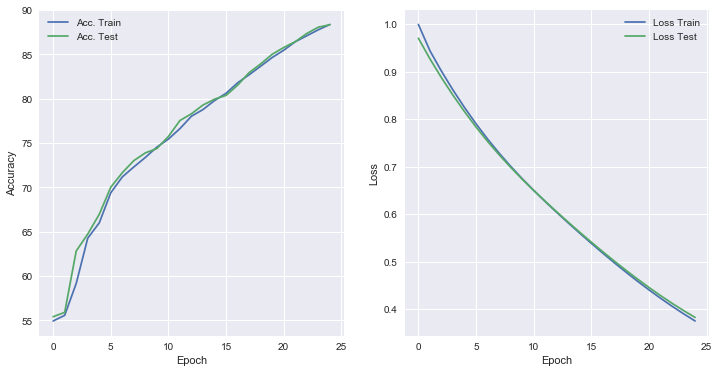

<Figure size 432x288 with 0 Axes>

In [14]:
# test if it worked
experiment_logs = np.load("data/grid_search_best_cnn_logs.npy")
test_exp = 10
plot(*experiment_logs[test_exp][:-1])

## Get the Top-5 Models for each Taxonomic Hierarchy

In [15]:
top_n = 5

phylum_model, class_model, order_model = [[i for i in experiment_logs if i[4]["model"] == x] for x in [0, 1, 2]]

# sort based on best test accuracy
phylum_model = sorted(phylum_model, key=lambda x: x[1][-1], reverse=True)
class_model = sorted(class_model, key=lambda x: x[1][-1], reverse=True)
order_model = sorted(order_model, key=lambda x: x[1][-1], reverse=True)

## Display Top-5 Model Performances for each Taxonomic Level

## Phylum-level

{'model': 0, 'lr': 0.01, 'weight_decay': 1e-06}
Train Accuracy: 100.0
Train Loss: 4.099032213521558e-06
Test Accuracy: 99.94550408719346
Test Loss: 0.0036661261108980516


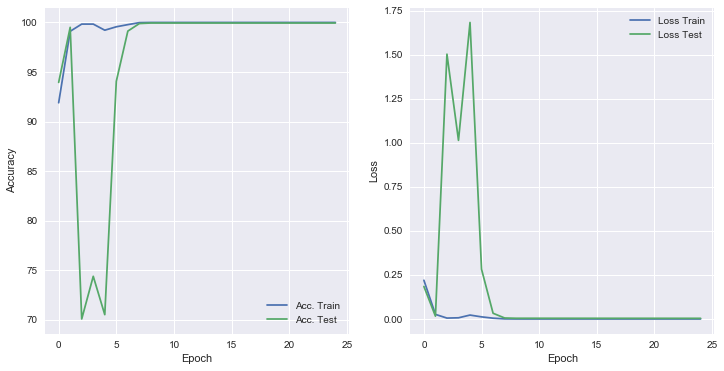

{'model': 0, 'lr': 0.01, 'weight_decay': 0.0001}
Train Accuracy: 100.0
Train Loss: 0.0001727176267047261
Test Accuracy: 99.89100817438693
Test Loss: 0.005138347194370197


<Figure size 432x288 with 0 Axes>

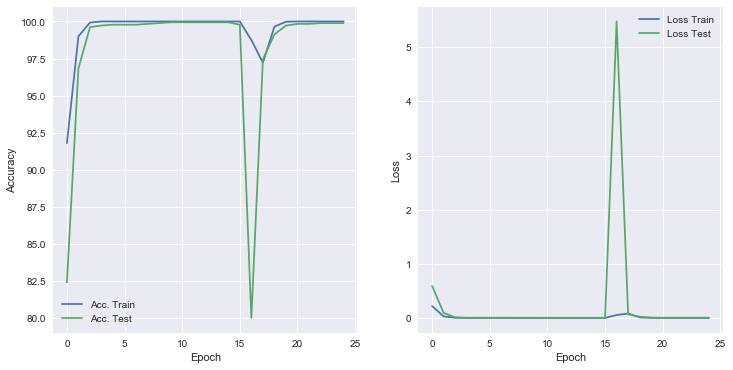

{'model': 0, 'lr': 0.001, 'weight_decay': 0.001}
Train Accuracy: 100.0
Train Loss: 0.00036104798836763516
Test Accuracy: 99.7275204359673
Test Loss: 0.008935328822694617


<Figure size 432x288 with 0 Axes>

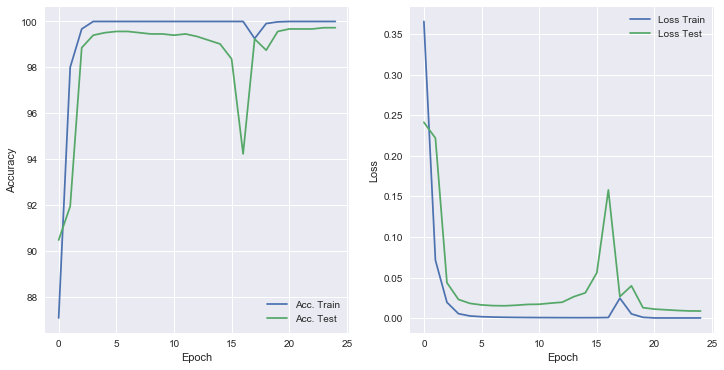

{'model': 0, 'lr': 0.01, 'weight_decay': 1e-05}
Train Accuracy: 100.0
Train Loss: 7.836537998776103e-06
Test Accuracy: 99.7275204359673
Test Loss: 0.006204425606480736


<Figure size 432x288 with 0 Axes>

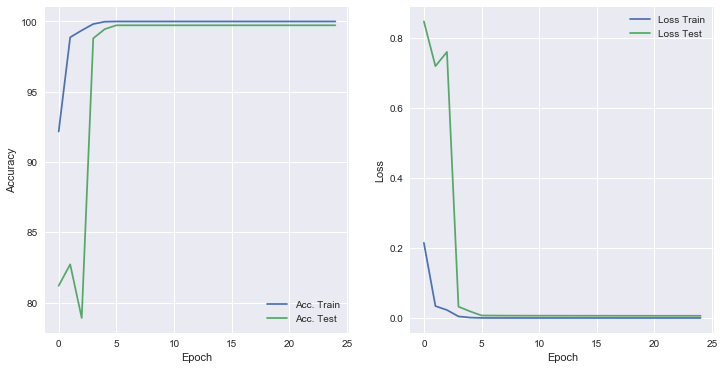

{'model': 0, 'lr': 0.001, 'weight_decay': 0.0001}
Train Accuracy: 100.0
Train Loss: 9.158877439277117e-05
Test Accuracy: 99.61852861035422
Test Loss: 0.013040821948558174


<Figure size 432x288 with 0 Axes>

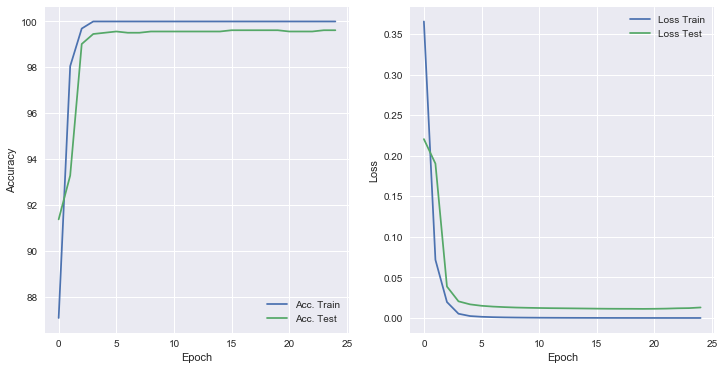

<Figure size 432x288 with 0 Axes>

In [16]:
for acc_train, acc_test, loss_train, loss_test, config in phylum_model[:top_n]:
    print(config)
    plot(acc_train, acc_test, loss_train, loss_test)

## Class-level

{'model': 1, 'lr': 0.01, 'weight_decay': 0.0001}
Train Accuracy: 100.0
Train Loss: 9.203546268995418e-05
Test Accuracy: 99.4550408719346
Test Loss: 0.023467805340114667


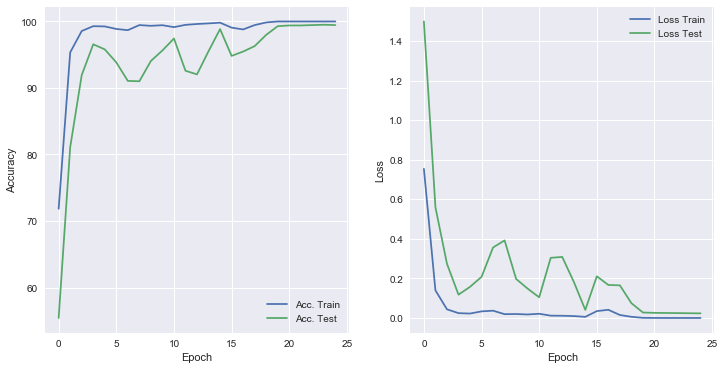

{'model': 1, 'lr': 0.01, 'weight_decay': 1e-06}
Train Accuracy: 100.0
Train Loss: 1.6747952200645624e-05
Test Accuracy: 99.23705722070845
Test Loss: 0.04325951555444369


<Figure size 432x288 with 0 Axes>

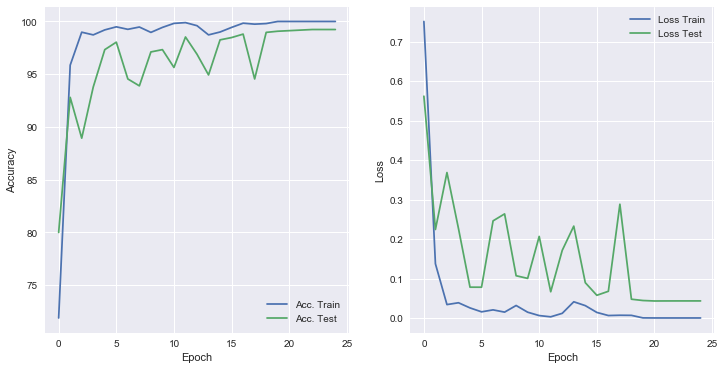

{'model': 1, 'lr': 0.001, 'weight_decay': 0.001}
Train Accuracy: 100.0
Train Loss: 0.0009181268166664035
Test Accuracy: 99.1825613079019
Test Loss: 0.022020277730125822


<Figure size 432x288 with 0 Axes>

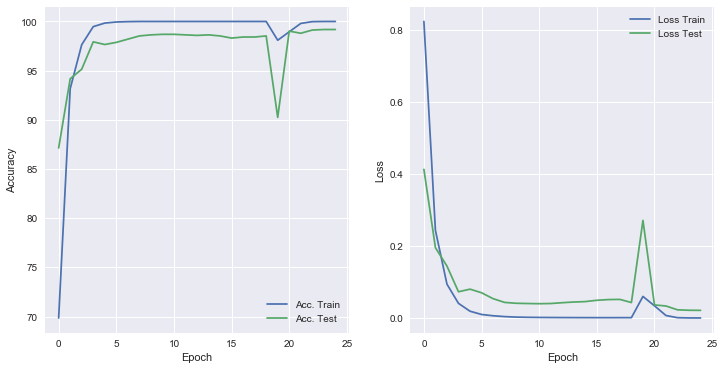

{'model': 1, 'lr': 0.001, 'weight_decay': 0.01}
Train Accuracy: 99.89098837209302
Train Loss: 0.01542015629279059
Test Accuracy: 98.96457765667574
Test Loss: 0.04392753206091941


<Figure size 432x288 with 0 Axes>

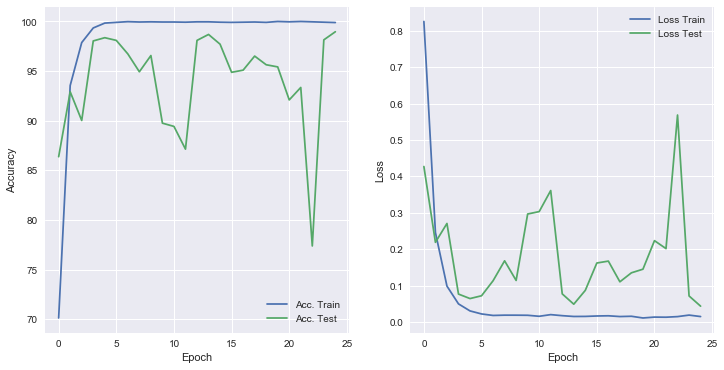

{'model': 1, 'lr': 0.001, 'weight_decay': 1e-06}
Train Accuracy: 100.0
Train Loss: 0.00018405095609121545
Test Accuracy: 98.91008174386921
Test Loss: 0.03270452207700433


<Figure size 432x288 with 0 Axes>

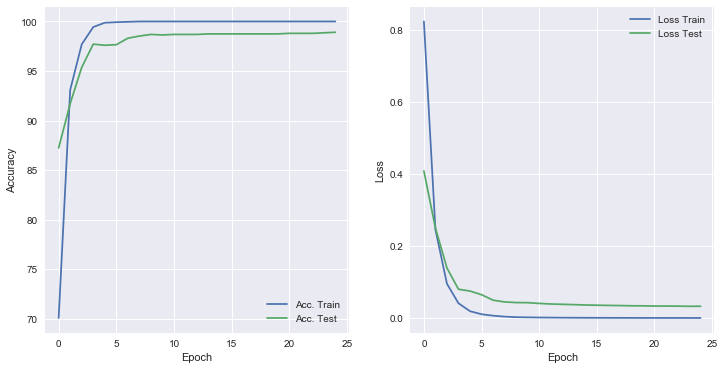

<Figure size 432x288 with 0 Axes>

In [17]:
for acc_train, acc_test, loss_train, loss_test, config in class_model[:top_n]:
    print(config)
    plot(acc_train, acc_test, loss_train, loss_test)

## Order-level

{'model': 2, 'lr': 0.01, 'weight_decay': 0.0001}
Train Accuracy: 100.0
Train Loss: 0.0004364191446193429
Test Accuracy: 94.55040871934605
Test Loss: 0.2662463108915074


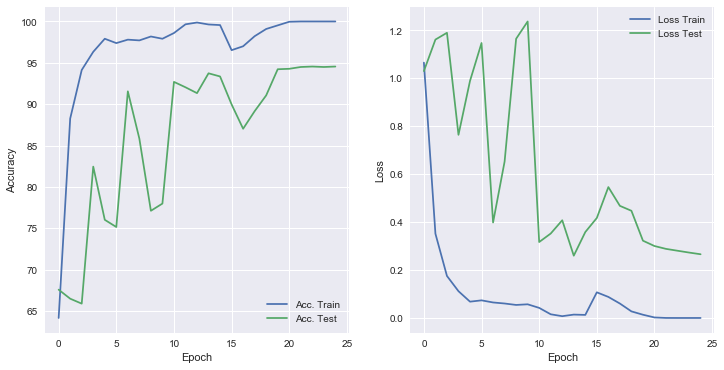

{'model': 2, 'lr': 0.001, 'weight_decay': 0.001}
Train Accuracy: 99.90915697674419
Train Loss: 0.011225902063902034
Test Accuracy: 94.27792915531334
Test Loss: 0.18268072942946847


<Figure size 432x288 with 0 Axes>

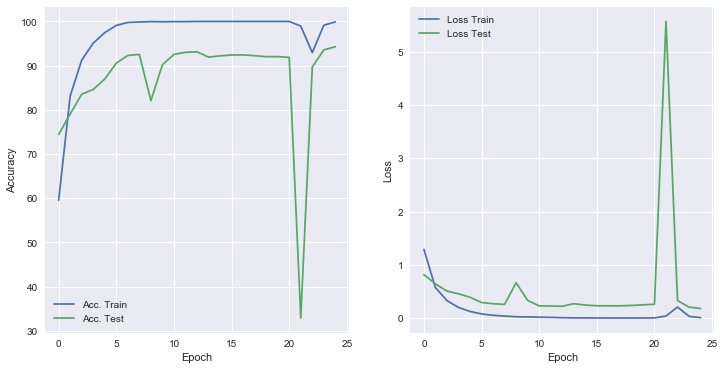

{'model': 2, 'lr': 0.01, 'weight_decay': 1e-05}
Train Accuracy: 100.0
Train Loss: 8.248061288234799e-05
Test Accuracy: 94.16893732970027
Test Loss: 0.27594940460995043


<Figure size 432x288 with 0 Axes>

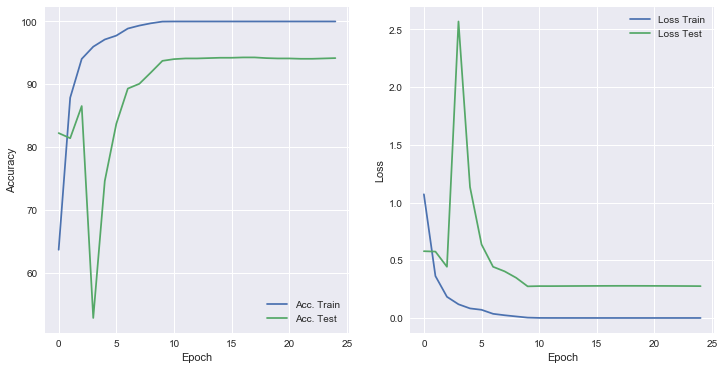

{'model': 2, 'lr': 0.001, 'weight_decay': 0.0001}
Train Accuracy: 100.0
Train Loss: 0.0010820851596288902
Test Accuracy: 93.7874659400545
Test Loss: 0.22943243437956723


<Figure size 432x288 with 0 Axes>

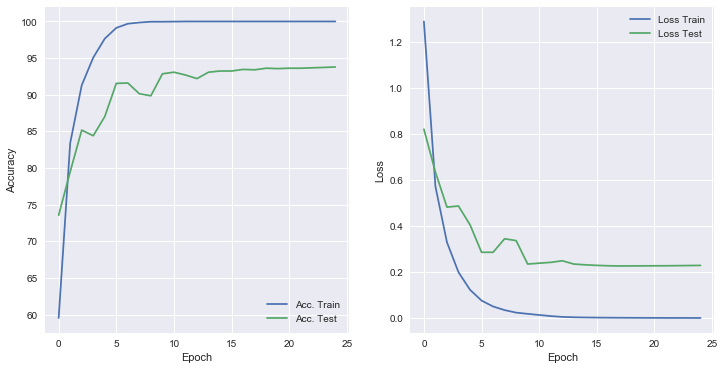

{'model': 2, 'lr': 0.001, 'weight_decay': 1e-05}
Train Accuracy: 100.0
Train Loss: 0.0008361590376427008
Test Accuracy: 93.62397820163488
Test Loss: 0.23820314998522765


<Figure size 432x288 with 0 Axes>

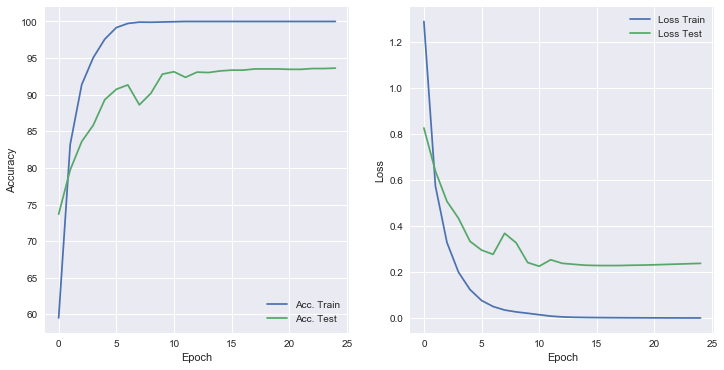

<Figure size 432x288 with 0 Axes>

In [18]:
for acc_train, acc_test, loss_train, loss_test, config in order_model[:top_n]:
    print(config)
    plot(acc_train, acc_test, loss_train, loss_test)

## Plot the Model Accuracies and Losses on the Grid Search space (3D Mesh Plot)

In [19]:
def get_items_to_plot(model):
    acc_train, acc_test, loss_train, loss_test, configs = list(zip(*model))

    get_final = lambda x: list(zip(*x))[-1]

    train_accuracies = get_final(acc_train)
    test_accuracies = get_final(acc_test)
    train_losses = get_final(loss_train)
    test_losses = get_final(loss_test)

    learning_rates, weight_decays = list(zip(*[(config["lr"], config["weight_decay"]) for config in configs]))
    
    return train_accuracies, test_accuracies, train_losses, test_losses, learning_rates, weight_decays

In [20]:
param_to_id = {n: float(i) for i, n in enumerate(np.geomspace(1e-6, 1e3, num=10))}

def remove_outliers(data, others, m=2, n=10):
#     criteria = abs(data - np.mean(data)) < m * np.std(data)
    criteria = data < n
 
    data[np.invert(criteria)] = max(data[criteria])

    truncated_others = list()
    for o in others:
#         o[np.invert(criteria)] = max(o[criteria])
        truncated_others.append(o)
    return data, truncated_others

def plot_performance_metric(metric, learning_rates, weight_decays, z_label, title, clip_outliers=False):
    fig = plt.figure(figsize=(14, 10))
    ax = fig.gca(projection='3d')
    
    X, Y = [param_to_id[l] for l in learning_rates], [param_to_id[w] for w in weight_decays]
    
    if clip_outliers:
        metric, (X, Y) = remove_outliers(np.array(metric), others=[np.array(X), np.array(Y)])

    # # changes for plot_surface()
    # params_to_metric = {(param_to_id[l], param_to_id[w]): m for m, l, w in zip(metric, learning_rates, weight_decays)}
    # X, Y = np.meshgrid(X, Y)
    # zs = np.array([params_to_metric[(x, y)] for x, y in zip(np.ravel(X), np.ravel(Y))])
    # Z = zs.reshape(X.shape)

    ax.plot_trisurf(X, Y, metric, cmap='viridis', edgecolor='none')
    
    ax.set_title(title + " (" + z_label + ")", fontsize=15, pad=15, weight='bold')
    ax.tick_params(labelsize=13)
    
    ax.xaxis.set_ticks(np.arange(10))
    ax.xaxis.set_ticklabels(np.geomspace(1e-6, 1e3, num=10))
    ax.set_xlabel('Learning Rate', labelpad=15, fontsize=13)
    
    ax.yaxis.set_ticks(np.arange(10))
    ax.yaxis.set_ticklabels(np.geomspace(1e-6, 1e3, num=10))
    ax.set_ylabel('Weight Decay', labelpad=15, fontsize=13)

    ax.set_zlabel(z_label, labelpad=15, fontsize=13)
    
    plt.show()

In [21]:
def plot_grid_search_plots(model, title):
    train_accuracies, test_accuracies, train_losses, test_losses, learning_rates, weight_decays = get_items_to_plot(model)
    plot_performance_metric(train_accuracies, learning_rates, weight_decays, z_label="Train Accuracy", title = title + "-level CNN Classifier")
    plot_performance_metric(test_accuracies, learning_rates, weight_decays, z_label="Test Accuracy", title = title + "-level CNN Classifier")
    plot_performance_metric(train_losses, learning_rates, weight_decays, clip_outliers=True, z_label="Train Loss", title = title + "-level CNN Classifier")
    plot_performance_metric(test_losses, learning_rates, weight_decays, clip_outliers=True, z_label="Test Loss", title = title + " CNN Classifier")

## Phylum-level

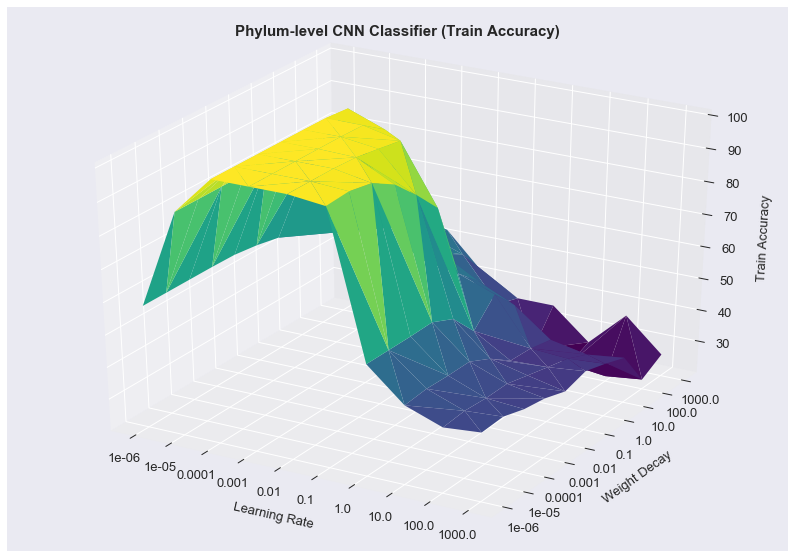

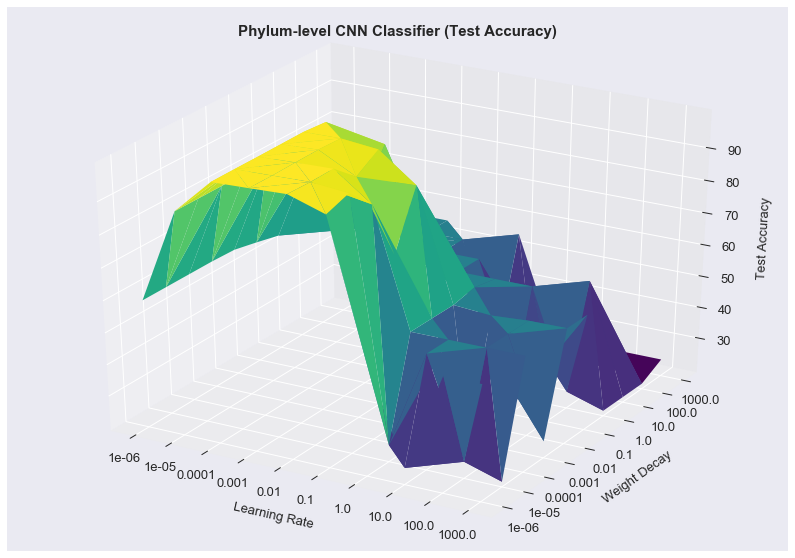

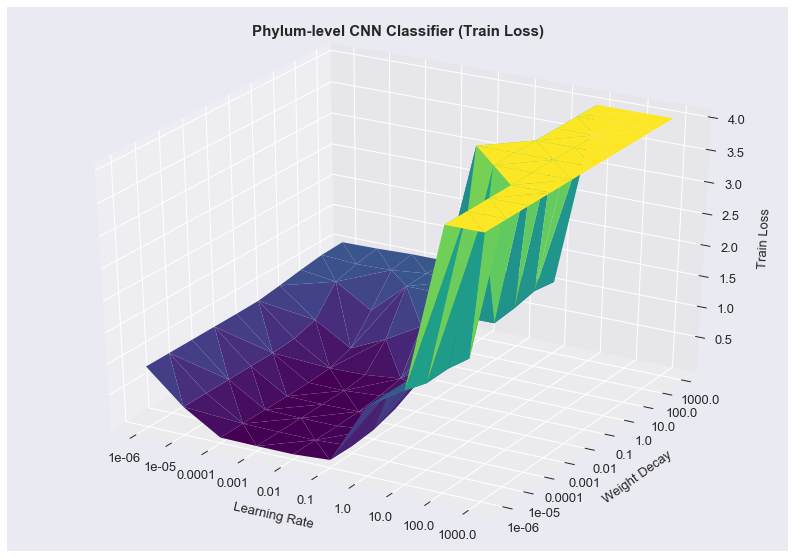

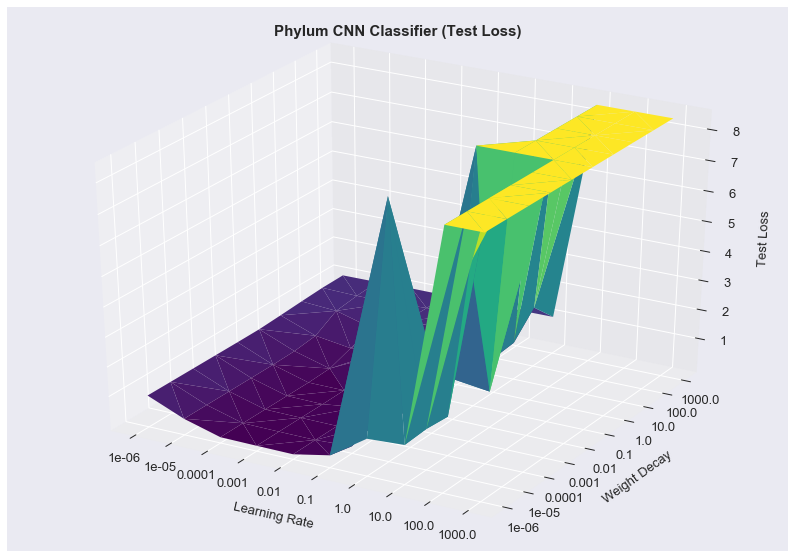

In [22]:
plot_grid_search_plots(phylum_model, "Phylum")

## Class-level

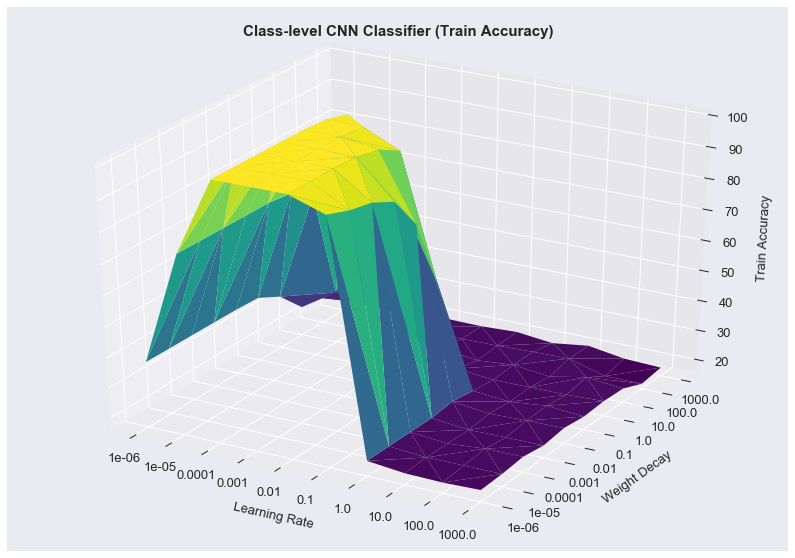

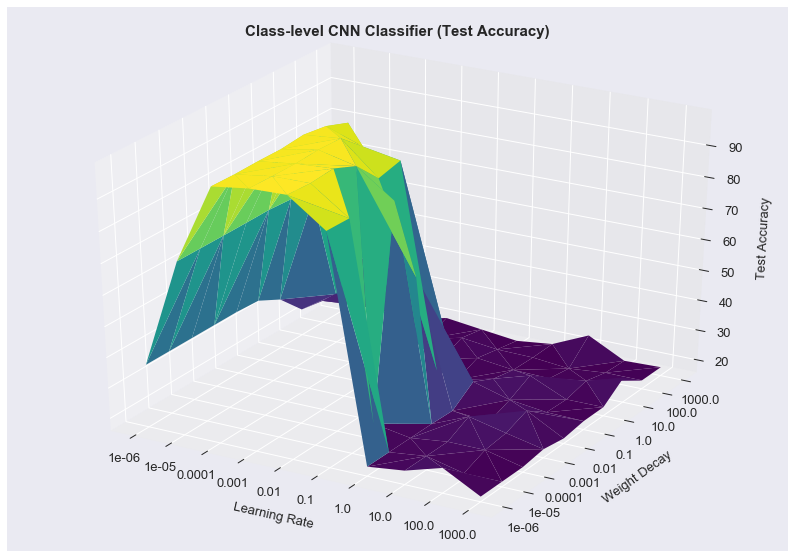

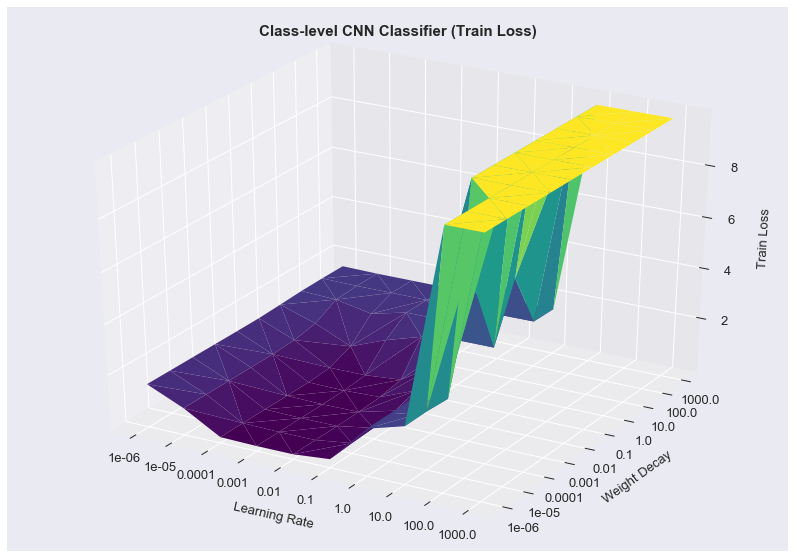

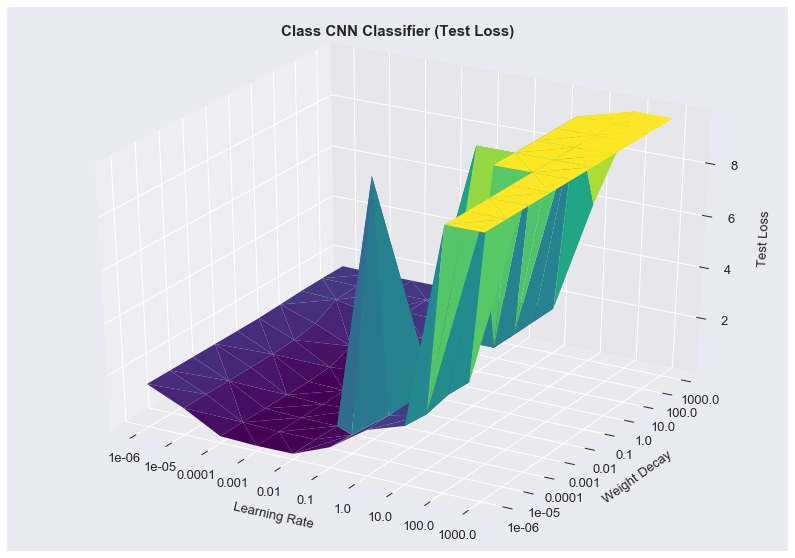

In [23]:
plot_grid_search_plots(class_model, "Class")

## Order-level

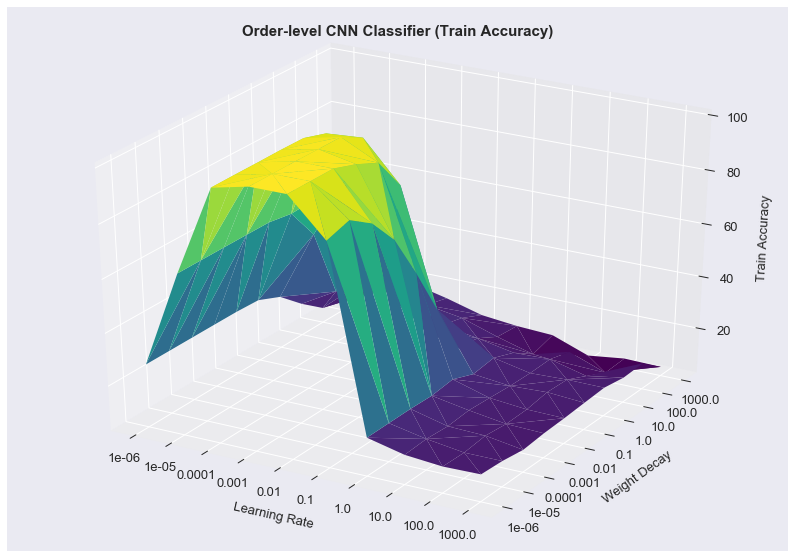

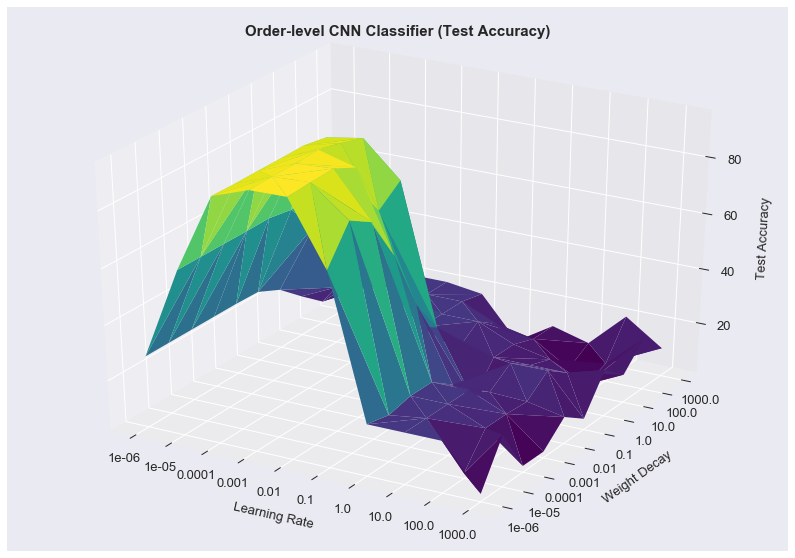

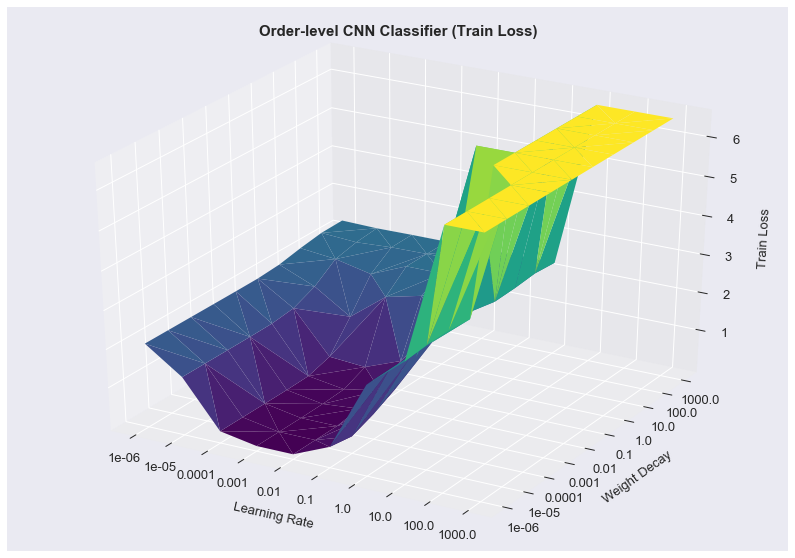

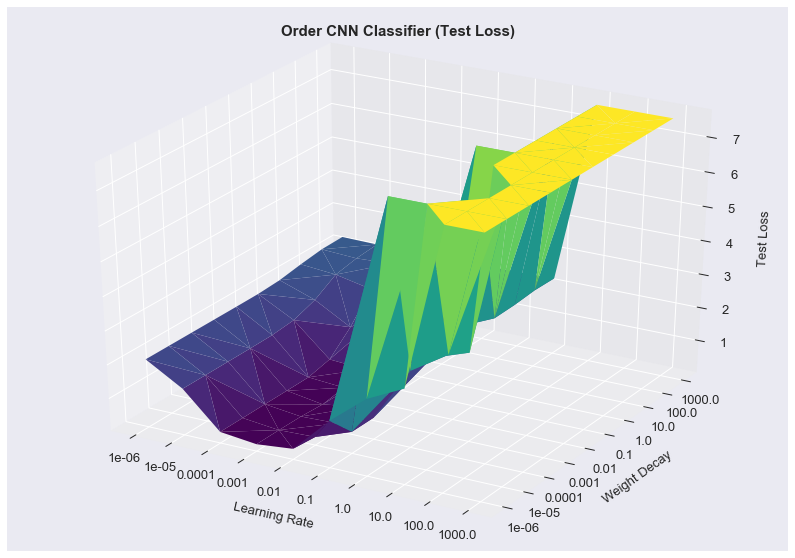

In [24]:
plot_grid_search_plots(order_model, "Order")

## Results: Best CNN Configurations for each Taxonomy Level
(Note: after obeserving the top 5 configurations and the above plots)

- **Phylum model:** {'lr': 0.01, 'weight_decay': 1e-05}
- **Class model:** {'lr': 0.01, 'weight_decay': 0.0001}
- **Order model:** {'lr': 0.01, 'weight_decay': 0.0001} 

**Next:** We will use the above best CNN paramters found using the validation dataset to train our final model and 
evaluate on our test dataset.

### Phylum-level best model

100% (25 of 25) |########################| Elapsed Time: 0:02:39 ETA:  00:00:00

Train Accuracy: 100.0
Train Loss: 8.952652299126914e-06
Test Accuracy: 99.4550408719346
Test Loss: 0.024748780032269636


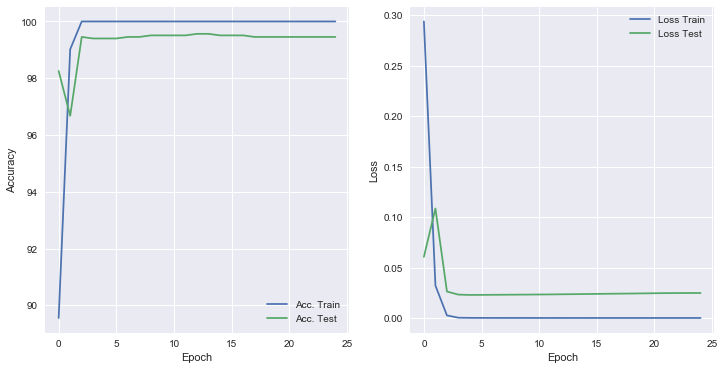

<Figure size 432x288 with 0 Axes>

In [30]:
logs = cnn_train_eval("phylum", ConvNet(3), eval_on="test", cnn_config={"lr": 0.01, "weight_decay": 1e-05}, is_plot=True)
phylum_trained_model = logs[-1]["trained_model"]

### Class-level best model

100% (25 of 25) |########################| Elapsed Time: 0:03:25 ETA:  00:00:00

Train Accuracy: 100.0
Train Loss: 0.00011084644600402477
Test Accuracy: 99.29155313351498
Test Loss: 0.03728742320141286


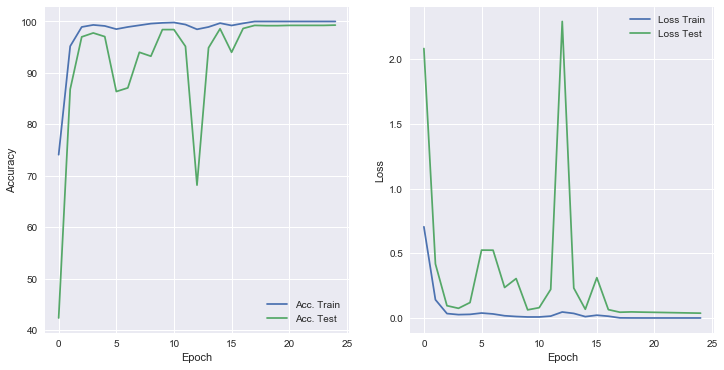

<Figure size 432x288 with 0 Axes>

In [26]:
logs = cnn_train_eval("class", ConvNet(5), eval_on="test", cnn_config={"lr": 0.01, "weight_decay": 0.0001}, is_plot=True)
class_trained_model = logs[-1]["trained_model"]

### Order-level best model

100% (25 of 25) |########################| Elapsed Time: 0:04:11 ETA:  00:00:00

Train Accuracy: 100.0
Train Loss: 0.000361061200152996
Test Accuracy: 95.80381471389646
Test Loss: 0.19313281641344285


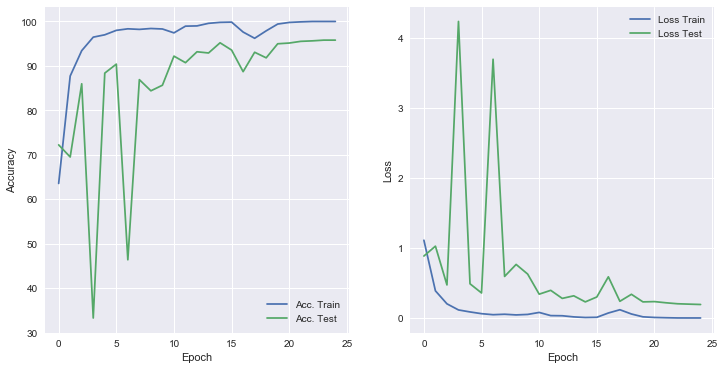

<Figure size 432x288 with 0 Axes>

In [29]:
logs = cnn_train_eval("order", ConvNet(10), eval_on="test", cnn_config={"lr": 0.01, "weight_decay": 0.0001}, is_plot=True)
order_trained_model = logs[-1]["trained_model"]

### Save all models for Activations Viz

In [31]:
torch.save(phylum_trained_model.state_dict(), "data/best_phylum_cnn_model")
torch.save(class_trained_model.state_dict(), "data/best_class_cnn_model")
torch.save(order_trained_model.state_dict(), "data/best_order_cnn_model")